### Etiquetado Automatico de las Palas de Padel 

In [4]:
import os
import json
import numpy as np 
import pandas as pd 
from sklearn.experimental import enable_iterative_imputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder

Cargamos el Fichero de Palas

In [68]:
# Obtener la ruta del directorio actual
current_dir = os.getcwd()

# Construir la ruta completa al archivo JSON
json_path = os.path.join(current_dir, 'caracteristicas_palas_padel.json')

# Leer el archivo JSON y cargar los datos en un DataFrame
try:
    # Abrir y cargar el archivo JSON
    with open(json_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Convertir los datos del JSON en un DataFrame
    data_df = pd.DataFrame(data)
    print("Archivo JSON cargado exitosamente.")
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo JSON. {e}")
    data_df = None
except json.JSONDecodeError as e:
    print(f"Error: El archivo no tiene un formato JSON válido. {e}")
    data_df = None

# Imprimir los datos en forma tabular (opcional)
if data_df is not None:
    pd.set_option('display.max_colwidth', None)  # Mostrar columnas completas sin truncar
    print("Datos cargados del archivo JSON:")
    print(data_df.head())  # Mostrar las primeras filas del DataFrame

Archivo JSON cargado exitosamente.
Datos cargados del archivo JSON:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             data
0  {'producto': {'nombre': 'NOX AT

La columna 'nivel de juego' está disponible.


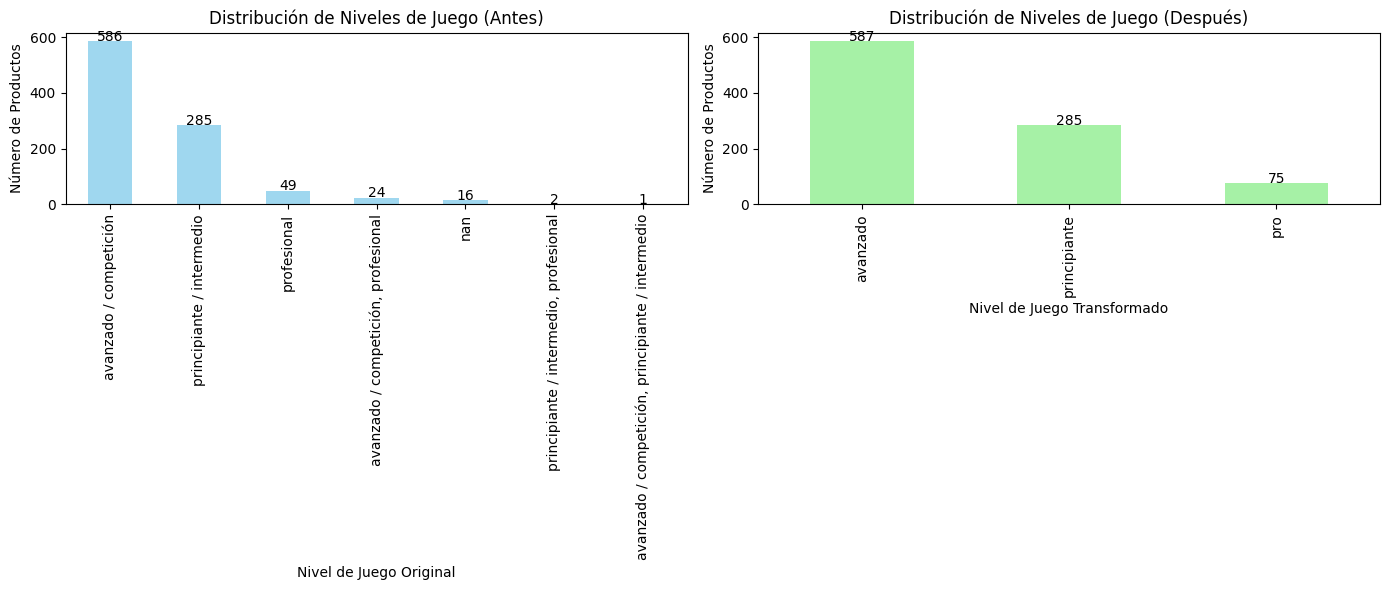


Porcentajes antes del cambio:
nivel_de_juego_original
avanzado / competición                               60.851506
principiante / intermedio                            29.595016
profesional                                           5.088266
avanzado / competición, profesional                   2.492212
NaN                                                   1.661475
principiante / intermedio, profesional                0.207684
avanzado / competición, principiante / intermedio     0.103842
Name: count, dtype: float64

Porcentajes después del cambio:
nivel_de_juego_transformado
avanzado        61.985216
principiante    30.095037
pro              7.919747
Name: count, dtype: float64

DataFrame final con targeting:
     nivel_de_juego_original nivel_de_juego_transformado  \
0     avanzado / competición                    avanzado   
1     avanzado / competición                    avanzado   
2  principiante / intermedio                principiante   
3     avanzado / competición         

In [72]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# Paso 1: Cargar el archivo JSON
current_dir = os.getcwd()
json_path = os.path.join(current_dir, 'caracteristicas_palas_padel.json')

with open(json_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Convertir los datos en un DataFrame
data_df = pd.DataFrame(data)

# Expandir la columna 'data' si existe
if 'data' in data_df.columns:
    # Normalizar la columna 'data' en un nuevo DataFrame
    data_df = pd.json_normalize(data_df['data'])

# Trabajar directamente con la columna 'producto.caracteristicas'
if 'producto.caracteristicas' in data_df.columns:
    # Extraer la columna 'producto.caracteristicas'
    data_df['caracteristicas'] = data_df['producto.caracteristicas'].apply(
        lambda x: {d['nombre']: d['valor'] for d in x} if isinstance(x, list) else {}
    )
    
    # Crear columnas individuales para cada característica
    caracteristicas_df = pd.json_normalize(data_df['caracteristicas'])
    data_df = pd.concat([data_df, caracteristicas_df], axis=1)
    
    # Confirmar si 'nivel de juego' está presente
    if 'nivel de juego' in data_df.columns:
        print("La columna 'nivel de juego' está disponible.")
        
        # Paso 2: Guardar los niveles originales para comparación posterior
        data_df['nivel_de_juego_original'] = data_df['nivel de juego']

        # Paso 3: Transformar los niveles de juego según las reglas definidas
        data_df['nivel_de_juego_transformado'] = data_df['nivel_de_juego_original'].apply(lambda x:
            'pro' if isinstance(x, str) and 'profesional' in x else
            'avanzado' if isinstance(x, str) and ('avanzado / competición' in x or 
                                                  'avanzado / competición, profesional' in x or 
                                                  'principiante / intermedio, profesional' in x) else
            'principiante' if isinstance(x, str) and 'principiante / intermedio' in x else None  # Valor por defecto
        )

        # Paso 4: Asignar el targeting numérico (2 para profesional, 1 para avanzado, 0 para principiante)
        targeting_dict = {'pro': 2, 'avanzado': 1, 'principiante': 0}
        data_df['nivel_de_juego_numeric'] = data_df['nivel_de_juego_transformado'].replace(targeting_dict)

        # Paso 5: Calcular las distribuciones antes y después del cambio
        niveles_antes = data_df['nivel_de_juego_original'].value_counts(dropna=False)
        niveles_despues = data_df['nivel_de_juego_transformado'].value_counts()

        # Paso 6: Crear gráficas comparativas
        plt.figure(figsize=(14, 6))

        # Gráfica inicial: Niveles originales
        plt.subplot(1, 2, 1)
        niveles_antes.plot(kind='bar', color='skyblue', alpha=0.8)
        plt.title('Distribución de Niveles de Juego (Antes)')
        plt.xlabel('Nivel de Juego Original')
        plt.ylabel('Número de Productos')
        for i, v in enumerate(niveles_antes):
            plt.text(i, v + 0.5, str(v), ha='center', fontsize=10)

        # Gráfica final: Niveles transformados
        plt.subplot(1, 2, 2)
        niveles_despues.plot(kind='bar', color='lightgreen', alpha=0.8)
        plt.title('Distribución de Niveles de Juego (Después)')
        plt.xlabel('Nivel de Juego Transformado')
        plt.ylabel('Número de Productos')
        for i, v in enumerate(niveles_despues):
            plt.text(i, v + 0.5, str(v), ha='center', fontsize=10)

        plt.tight_layout()
        plt.show()

        # Paso 7: Mostrar porcentajes antes y después del cambio (opcional)
        print("\nPorcentajes antes del cambio:")
        print((niveles_antes / niveles_antes.sum()) * 100)

        print("\nPorcentajes después del cambio:")
        print((niveles_despues / niveles_despues.sum()) * 100)

        # Mostrar las primeras filas del DataFrame final con targeting
        print("\nDataFrame final con targeting:")
        print(data_df[['nivel_de_juego_original', 'nivel_de_juego_transformado', 'nivel_de_juego_numeric']].head(10))
        
    else:
        print("La columna 'nivel de juego' no está disponible después del procesamiento.")
else:
    print("La columna 'producto.caracteristicas' no está disponible.")

# Guardar el DataFrame completo en un archivo JSON en la misma carpeta
output_json_path = os.path.join(current_dir, 'dataframe_resultado.json')
data_df.to_json(output_json_path, orient='records', lines=True)
print(f"\nEl DataFrame completo se ha guardado como JSON en: {output_json_path}")